<a href="https://colab.research.google.com/github/mr-nastik/UrbanSound8k/blob/main/Gaurav_UrabanSound8K_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH='/content/gdrive/My Drive/urbansound8k/'


In [ ]:
!ls

gdrive	sample_data


In [ ]:
!pip install soundfile

In [ ]:
!pip install livelossplot

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from livelossplot import PlotLossesKeras

#for data handaling
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#for calc accuaracy and spliting the data
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

#for sound
import librosa
import librosa.display
import glob 
import skimage
import soundfile as sf
from scipy.io.wavfile import read

In [ ]:
df=pd.read_csv(PATH+'UrbanSound8K.csv')
print(df.head())
print(df.tail())
print("shape of train.csv: ",df.shape)

      slice_file_name    fsID  start  ...  fold  classID             class
0    100032-3-0-0.wav  100032    0.0  ...     5        3          dog_bark
1  100263-2-0-117.wav  100263   58.5  ...     5        2  children_playing
2  100263-2-0-121.wav  100263   60.5  ...     5        2  children_playing
3  100263-2-0-126.wav  100263   63.0  ...     5        2  children_playing
4  100263-2-0-137.wav  100263   68.5  ...     5        2  children_playing

[5 rows x 8 columns]
      slice_file_name   fsID       start  ...  fold  classID     class
8727  99812-1-2-0.wav  99812  159.522205  ...     7        1  car_horn
8728  99812-1-3-0.wav  99812  181.142431  ...     7        1  car_horn
8729  99812-1-4-0.wav  99812  242.691902  ...     7        1  car_horn
8730  99812-1-5-0.wav  99812  253.209850  ...     7        1  car_horn
8731  99812-1-6-0.wav  99812  332.289233  ...     7        1  car_horn

[5 rows x 8 columns]
shape of train.csv:  (8732, 8)


In [ ]:
type(df['class'][0])

str

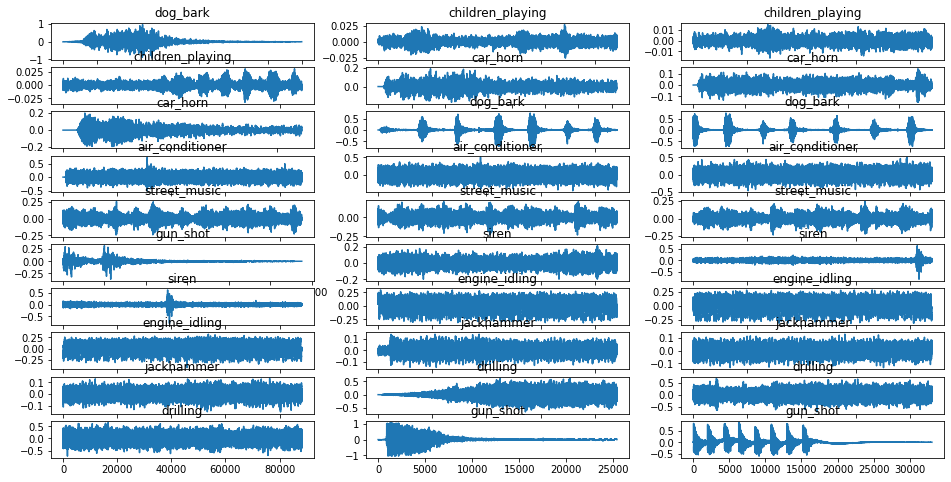

In [ ]:
f, ax = plt.subplots(10, 3, figsize=(16, 8))
ax = ax.flatten()
a=[0,0 ,0, 0 ,0 ,0 ,0 ,0 ,0 ,0]
k=0
i=0
while(i<30):
    if a[df['classID'][k]]>=3:
        k+=1
        continue
    a[df['classID'][k]]+=1
    sound,sr=librosa.load(PATH+'fold'+str(df['fold'][k])+'/'+df['slice_file_name'][k],res_type='kaiser_fast')
    ax[i].set_title(df['class'][k])
    ax[i].plot(sound)
    i+=1
    k+=1

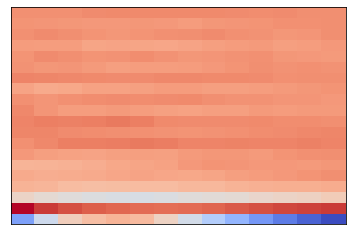

In [ ]:
#f, ax = plt.subplots(10, 3, figsize=(16, 8))
#ax = ax.flatten()
a=[0,0 ,0, 0 ,0 ,0 ,0 ,0 ,0 ,0]
k=0
i=0
while(i<1):
    if a[df['classID'][k]]>=3:
        k+=1
        continue
    a[df['classID'][k]]+=1
    sound,sr=librosa.load(PATH+'fold'+str(df['fold'][k])+'/'+df['slice_file_name'][k],res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(sound, sr=sr)
    #ax[i].set_title(df['class'][k])
    librosa.display.specshow(mfccs, sr=sr)
    i+=1
    k+=1

In [ ]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes of selected feature; feature is a categorical value
    param: feature - the feature for which we present the distribution of classes
    param: title - title to show in the plot
    param: df - dataframe 
    param: size - size (from 1 to n), multiplied with 4 - size of plot
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.savefig('freq of '+feature+'.png', dpi=300, bbox_inches='tight')
    plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


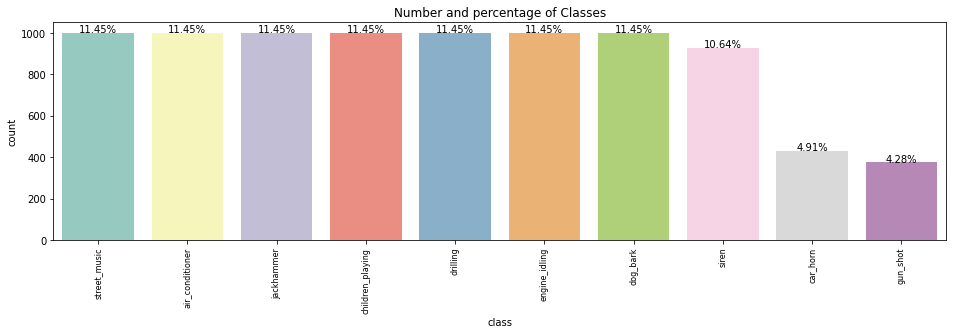

In [ ]:
plot_count('class', 'Classes', df, size=4)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


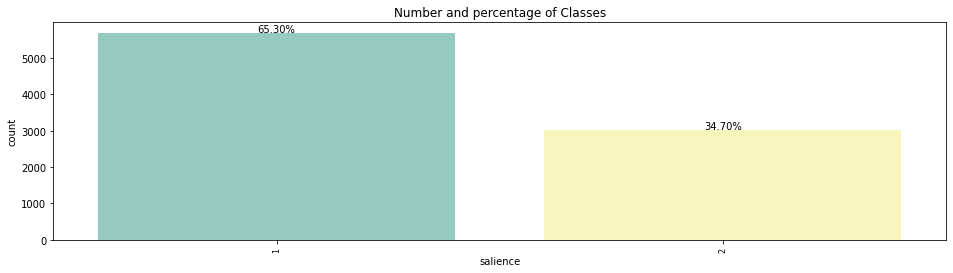

In [ ]:
plot_count('salience', 'Classes', df, size=4)

In [ ]:
X=[]
Y=[]
for i in tqdm(range(8732)):
    data,sr=librosa.load(PATH+'fold'+str(df['fold'][i])+'/'+df['slice_file_name'][i],res_type='kaiser_fast')
    data=librosa.feature.spectral_centroid(y=data,sr=sr)
    data=np.mean(data,axis=1)
    X.append(data)
    Y.append(df['classID'][i])


(173,)


In [ ]:
X=np.array(X)
Y=np.array(Y)
Y=keras.utils.to_categorical(Y)
X.shape
Y.shape

(8732, 128)

In [ ]:
print(X)

[array([2.11046015e-01, 4.23125599e+00, 1.06005965e+01, 1.25370383e+01,
       1.70006814e+01, 1.29155823e+01, 4.28369980e+00, 1.02543523e+00,
       3.42190944e-01, 1.03247885e-01, 3.54904435e-02, 1.73917815e-02,
       8.42880773e-03, 3.57884046e-03])
 array([0.00097922, 0.00158448, 0.00124777, 0.00136323, 0.0034324 ,
       0.00438648, 0.00269138, 0.00248526, 0.00305456, 0.00239422,
       0.00169414, 0.0024116 , 0.00196245, 0.00192941, 0.0019947 ,
       0.00202398, 0.00281173, 0.00233549, 0.0011642 , 0.00178431,
       0.00257106, 0.00381581, 0.00400601, 0.00483305, 0.00654919,
       0.00648643, 0.00554482, 0.00412723, 0.00396725, 0.00392013,
       0.00434788, 0.00512164, 0.00567944, 0.0048951 , 0.00485097,
       0.0043647 , 0.00549168, 0.00472972, 0.00233037, 0.00159532,
       0.00268385, 0.00329182, 0.00320453, 0.00365424, 0.00310382,
       0.00165506, 0.0011854 , 0.00167155, 0.00228987, 0.00230081,
       0.00262763, 0.00188916, 0.0021542 , 0.0029432 , 0.00299234,
       0

(8732, 10)

In [ ]:
np.save(PATH+'spectral_centroid_ks_X.npy',X)


In [ ]:
np.save(PATH+'spectral_centroid_ks_Y.npy',Y)
